# Human-In-The-Loop 반영하기

In [ ]:
"""
Al 모델이 아무리 성능이 좋아져도, 사람의 생각을 읽을 수는 없습니다. 
LLM은 좋은 결과를 내기 위해 최선을 다하지만 사람이 의도하지 않은 방향으로 최선을 다한 결과는 실망스러울 수밖에 없습니다. 
결국 LLM이 사람이 의도한 바를 알려면, 사람의 개입이 필요합니다. 또한 LLM이 갈 길을 몰라 헤매고 있다면 
사람이 힌트를 줄 수도 있습니다. 이를 휴먼 인 더 루프Human-In-the-loop라고 부릅니다. 
휴먼 인 더 루프의 단계는 보통 다음과 같이 4단계입니다.

1. 중단점(Breakpoint) : AI가 인간의 개입이 필요한 지점을 인식

2. 컨텍스트 제공: 인간이 올바른 결정을 내릴 수 있도록 충분한 정보 제공

3. 피드백 수집 : 구조화된 방식으로 인간의 입력 수집

4. 재개(Resume) : 인간의 결정에 따라 워크플로 계속 진행

휴먼 인 더 루프를 어떻게 구현하면 될지 랭그래프를 사용해서 간단하게 만듭시다.
"""
None

# import

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel, Field
from IPython.display import Image, display

# State 상태 정의

In [3]:
class AgentState(BaseModel):
    user_message: str = Field(default="", description="사용자 입력 작업")
    task_details: str = Field(default="", description="작업 상세 정보")
    response: str = Field(default="", description="응답 결과")

# 노드 함수 정의

In [4]:
# 사용자가 상세정보를 제공했다면 최종 보고서를 생성하고, 
# 그렇지 않다면 LLM이 사용자에게 추가 정보를 요청하도록 프롬프트를 구성합니다. 
# 이 노드는 상태의 task_details 필드를 확인하여 현재 대화의 단계를 파악하고 적절한 응답을 생성합니다.

def get_llm_response_node(state: AgentState, llm):  # 나중에 이 함수의 결과를 리턴하는 노드함수를 정의할거다.
    details = state.task_details

    if details:
        print(f"\n상세 정보를 바탕으로 작업 실행: '{details}'")
        prompt = f"다음 요청에 따라 보고서를 작성해주세요: {details}"
    else:
        task = state.user_message
        print(f"\n작업 실행: '{task}' 작업을 수행합니다...")

        prompt = f"""
            '{task}' 작업을 수행하려고 합니다. 어떤 종류의 보고서가 필요한지, 구체적인 주제는 무엇인지 질문해주세요. 
            추가 정보가 필요하면, 반드시 응답의 마지막을 물음표('?')로 끝내주세요.
        """

    response = llm.invoke(prompt).content

    print("--- LLM 응답 ---")
    print(response)
    print("-" * 20)

    return {"response": response, "task_details": ""}



# 사람의 입력을 받는 노드

In [5]:
# 워크플로의 실행을 일시 중지 하고 사용자의 입력을 대기 
# LLM 이 요청한 추가 정보를 사용자로부터 수집하여 task_details 필드에 저장합니다.
# 이 노드는 AI 와 인간 간의 대화형 상호 작용을 가능하게 하는 다리 역할.

In [6]:
def get_task_details_node(state: AgentState):
    """LLM 의 질문에 대한 사용자 답변을 입력받는 노드"""
    print("\nLLM 의 질문에 답변해주세요")
    user_input = input("답변:")
    return {"task_details": user_input}

# 조건부 분기 노드

In [ ]:
# LLM 응답패턴을 분석하여 다음 경로를 결정 
# 응답이 물음표로 끝나면 get_details 노드로 분기하여 사용자 입력 받고
# 그렇지 않으면 최종결과생성으로 판단. 워크플로 종료.

In [7]:
def check_llm_response(state: AgentState) -> Literal["get_details", "end"]:
    print("LLM 응답 분석 중...")
    if state.response.strip().endswith("?"):
        print("LLM 이 추가 정보를 요청했습니다.  사용자 입력을 받습니다.")
        return "get_details"

    print("최종 보고서가 생성되었스빈다. 워크플로우를 종료합니다.")
    return "end"

# 그래프(워크플로) 생성

In [8]:
def create_graph():
    llm = init_chat_model("gpt-4o", model_provider="openai")

    def get_llm_response_with_llm(state):
        return get_llm_response_node(state, llm)

    workflow = StateGraph(AgentState)
    workflow.add_node("get_llm_response", get_llm_response_with_llm)
    workflow.add_node("get_details", get_task_details_node)

    workflow.add_edge(START, "get_llm_response")
    workflow.add_conditional_edges(
        "get_llm_response",
        check_llm_response,
        {
            "get_details": "get_details",
            "end": END,
        }
    )

    workflow.add_edge("get_details", "get_llm_response")
    return workflow.compile()
    

# 실행

In [9]:
app = create_graph()

final_state = app.invoke(AgentState(user_message="블로그 글 작성"))

print("\n--- 워크플로우 종료 ---")
print("최종응답:")
print(final_state["response"])


작업 실행: '블로그 글 작성' 작업을 수행합니다...
--- LLM 응답 ---
물론입니다! 블로그 글 작성을 위한 구체적인 방향을 설정하기 위해 몇 가지 질문을 드리겠습니다:

1. 블로그 글의 주요 독자층은 누구인가요? 특정 연령대, 직업군, 혹은 관심사를 가지고 있는지요?
2. 블로그 글 작성의 목적은 무엇인가요? 정보 제공, 의견 공유, 제품 홍보 등 구체적인 목표가 있으신가요?
3. 다루고자 하는 특정 주제나 산업이 있나요? 예를 들어 기술, 여행, 건강 등 특정 분야에 대해 작성하고 싶으신가요?
4. 글의 길이나 형식에 대한 요구사항이 있나요? 짧은 글, 심층 분석, 리스트 형식 등 선호하는 형식이 있나요?
5. 참고하거나 인용할 만한 자료나 데이터 출처가 있으면 알려주실 수 있나요?
--------------------
LLM 응답 분석 중...
LLM 이 추가 정보를 요청했습니다.  사용자 입력을 받습니다.

LLM 의 질문에 답변해주세요


답변: 겨울 추위 극복 방법



상세 정보를 바탕으로 작업 실행: '겨울 추위 극복 방법'
--- LLM 응답 ---
겨울철 추위 극복 방법에 대한 보고서

겨울철 추위는 많은 사람들이 겪는 도전 과제 중 하나입니다. 추운 날씨는 우리의 일상생활을 불편하게 할 뿐만 아니라 건강에도 다양한 영향을 미칠 수 있습니다. 따라서 효과적으로 겨울 추위를 극복하기 위한 여러 가지 방법을 이해하고 실천하는 것이 중요합니다.

1. **적절한 의복 착용**
   - 여러 겹으로 옷을 겹쳐 입는 레이어링(Layering) 기법을 활용하세요. 이는 몸의 열기를 유지하면서도 필요에 따라 쉽게 온도 조절을 할 수 있도록 도와줍니다.
   - 방수 및 방풍 기능이 있는 외투를 선택해 찬 바람을 막고 체온을 보존하세요.
   - 모자, 장갑, 목도리 등을 착용해 열 손실을 최소화하세요. 머리를 포함한 신체의 말단 부분에서 많은 열 손실이 발생합니다.

2. **실내 환경 관리**
   - 실내 온도를 적절히 유지하세요. 권장되는 실내 온도는 대략 20°C 이상입니다.
   - 가습기를 사용해 실내 습도를 40-60% 사이로 유지하면 쾌적함을 높이고 호흡기 건강에 도움이 됩니다.
   - 단열재가 충분히 설치되어 있는지 확인하고 창문이나 문틈으로 찬 바람이 들어오지 않도록 막습니다.

3. **균형 잡힌 영양 섭취**
   - 추운 날씨에서는 체온 유지를 위해 에너지 소모가 증가하므로 지방, 단백질, 탄수화물 등 다양한 영양소를 골고루 섭취해야 합니다.
   - 따뜻한 음식과 음료를 섭취해 몸을 데우고 면역력을 강화하세요. 생강차, 계피차, 닭고기 수프 등이 좋은 선택입니다.

4. **정기적인 운동**
   - 실내에서 가벼운 스트레칭이나 요가를 통해 혈액순환을 촉진시키고 체온을 높일 수 있습니다.
   - 겨울철 야외 운동 시에는 따뜻하게 입고, 시작 전과 후에 충분한 준비운동과 마무리 운동을 통해 부상을 예방하세요.

5. **수면과 휴식**
   - 규칙적인 수면 습관을 통해 면역력을 강화하고 피로를 줄이세요

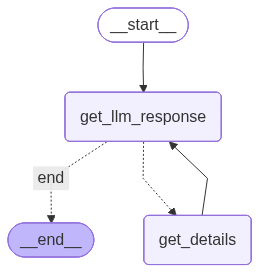

In [10]:
Image(app.get_graph().draw_mermaid_png())